In [1]:
import re
import json
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

### re 

In [42]:
can_info_raw = '''* Speed(km/h)
    * ID =   AC2
    * Start Bit   = 72
    * Length =   8
    * Factor  = 1
    * Offset =    0

* SoC
    * ID = 625
    * Start Bit = 88
    * Length = 8
    * Factor = 0.005
    * Offset = 0'''

In [43]:
can_info = re.sub('\s+=\s+', ': ', can_info_raw)
can_info = re.sub(' *\* +', '', can_info)

In [44]:
can_info_list = []
for can_info in can_info.split('\n\n'):
    can_info = 'Title: ' + can_info
    
    can_info_dict = {}
    for line in can_info.split('\n'):
        key, value = line.split(': ')
        can_info_dict[key] = value
    
    can_info_list.append(can_info_dict)

In [92]:
can_info_df = pd.DataFrame(can_info_list)
can_info_df

,Title,ID,Start Bit,Length,Factor,Offset
0,Speed(km/h),AC2,72,8,1,0
1,SoC,625,88,8,0.005,0


### 데이터 로드

In [97]:
def data_load(path):
    with open(path, 'r') as f:
        df = pd.read_csv(f, delimiter=' ', names=['time', 'type', 'value'])

    df = df.drop(columns="type")

    return df

In [98]:
path = './candump-sample.log'

raw_df = data_load(path)

### 데이터 전처리

#### 날짜 변환

In [99]:
def time_to_date(df):
    df['time'] = df['time'].str[1:-1].astype(float)
    df['time'] = np.vectorize(datetime.datetime.fromtimestamp)(df['time'].values)

    return df

In [100]:
df = time_to_date(raw_df)
df.head(3)

,time,value
0,2023-06-22 13:17:58.537614,605##56CECCA5000000001000035055300001000400000...
1,2023-06-22 13:17:58.572064,640##5D32DD400000000020203000001000000
2,2023-06-22 13:17:58.577831,9C7##590D0002000000000


#### ID, Data 분리

In [101]:
def data_of(row):
    data = row['value'].split('#')[-1]
    if row['is_can_fd']:
        data = data[1:]
        
    return data

def separate_id_data(df):
    df['id'] = df['value'].str[:3]
    df['is_can_fd'] = df['value'].str.contains('##')
    df['data'] = df.apply(data_of, axis=1)
    df = df.drop(columns='value')
    return df

In [102]:
df = separate_id_data(df)
df.head(3)

,time,id,is_can_fd,data
0,2023-06-22 13:17:58.537614,605,True,6CECCA5000000001000035055300001000400000040000...
1,2023-06-22 13:17:58.572064,640,True,D32DD400000000020203000001000000
2,2023-06-22 13:17:58.577831,9C7,True,90D0002000000000


### 데이터 추출

In [103]:
def hex_to_bin(s):
    return f'{int(s, 16):b}'.zfill(len(s)*4)

def extract_bit_from_hex(s, startbit, length):
    startbit = int(startbit)
    length = int(length)
    b = hex_to_bin(s)
    endbit = startbit + length
    return b[startbit:endbit]

def convert_can(x, can_info):
    startbit, length = can_info['Start Bit'], can_info['Length']
    b = extract_bit_from_hex(x, startbit, length)
    
    i = int(b, 2)
    
    factor, offset = can_info['Factor'], can_info['Offset']
    factor = float(factor)
    offset = float(offset)
    n = i * factor + offset
    
    return n

In [104]:
def process_can(df, can_info_list):
    for can_info in can_info_list:
        can_id = can_info['ID']
        mask = (df['id'] == can_id)
        
        df[can_info['Title']] = df.loc[mask, 'data'].apply(convert_can, can_info=can_info)

In [105]:
process_can(df, can_info_list)

In [111]:
df.head(10)

,time,id,is_can_fd,data,Speed(km/h),SoC
0,2023-06-22 13:17:58.537614,605,True,6CECCA5000000001000035055300001000400000040000...,NaN,NaN
1,2023-06-22 13:17:58.572064,640,True,D32DD400000000020203000001000000,NaN,NaN
2,2023-06-22 13:17:58.577831,9C7,True,90D0002000000000,NaN,NaN
3,2023-06-22 13:17:58.743256,605,True,905DDE5000000001000035055300001000400000040000...,NaN,NaN
4,2023-06-22 13:17:58.769723,AC2,True,103F7F10706000000000000000000000,0.0,NaN
5,2023-06-22 13:17:58.863695,745,True,4FC9D40000000000FF0300000101520001000000CF030000,NaN,NaN
6,2023-06-22 13:17:58.932608,F93,True,697F000000000001,NaN,NaN
7,2023-06-22 13:17:58.997205,9C7,True,8840002000000000,NaN,NaN
8,2023-06-22 13:17:59.031453,605,True,44E8FB5000000001000035055300001000400000040000...,NaN,NaN
9,2023-06-22 13:17:59.060682,9C7,True,5E70002000000000,NaN,NaN


### 시각화

In [108]:
# 차량 정보 데이터 구분
dfs = {can_info['Title']: df[['time', can_info['Title']]].dropna() for can_info in can_info_list}
dfs['SoC'].head()

,time,SoC
348,2023-06-22 13:18:17.181112,0.940
677,2023-06-22 13:18:33.599731,0.940
1229,2023-06-22 13:18:58.178452,0.940
2080,2023-06-22 13:19:41.426470,0.940
3466,2023-06-22 13:20:43.443612,0.935


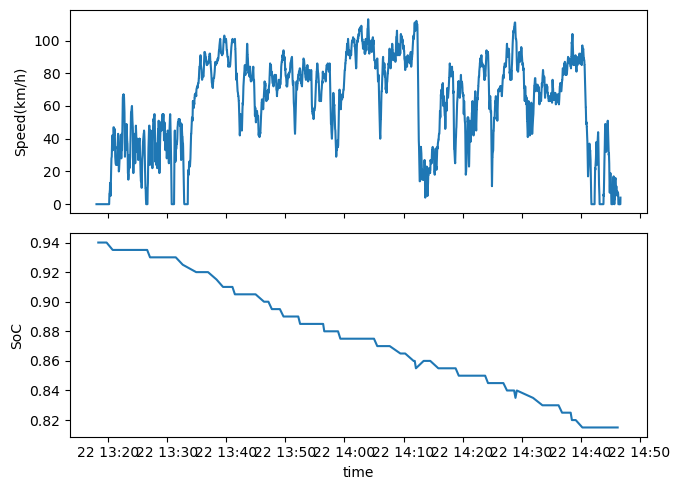

In [110]:
titles = [can_info['Title'] for can_info in can_info_list]

fig, axs = plt.subplots(
    nrows=len(titles), 
    ncols=1,
    figsize=(7, 5),
    sharex='col',
    sharey='row',
)

for i, title in enumerate(titles):
    sns.lineplot(ax=axs[i], data=dfs[title], x='time', y=title)
plt.tight_layout()
plt.show()